In [8]:
library(tidyverse)
library(ggrepel)

In [9]:
data <- read_tsv("frequencies.txt")

Rows: 202 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): livello_CEFR, lemma
dbl (2): occurrences, percent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
df_unique <- data %>%
  group_by(lemma) %>%
  summarise(groups = paste(unique(livello_CEFR), collapse = ", "))

write_tsv(df_unique, "unique.txt")

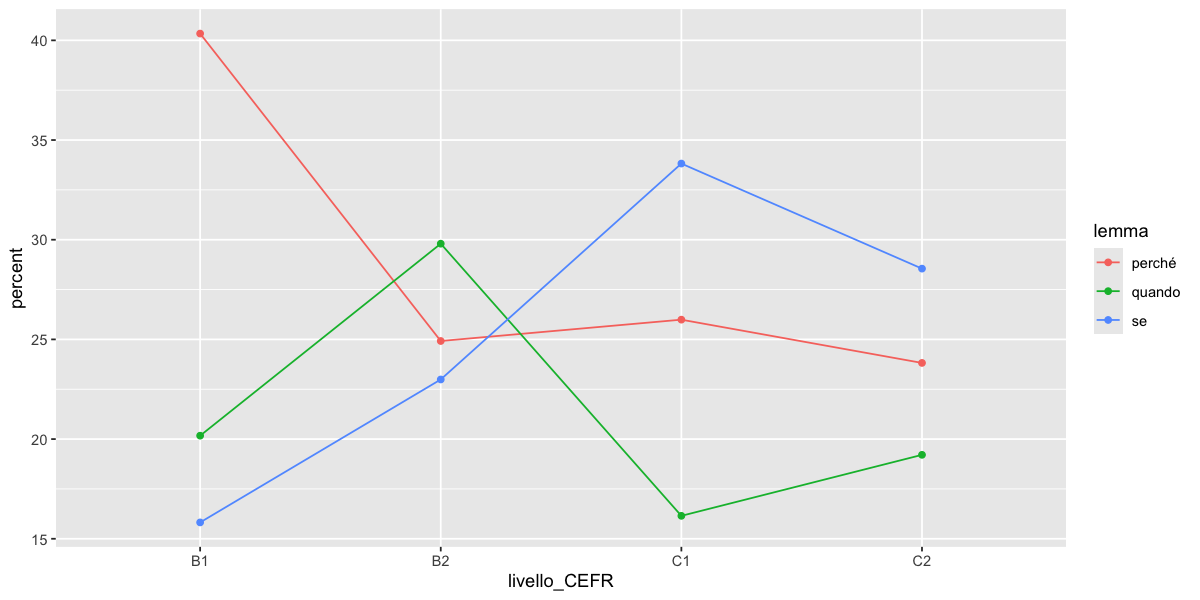

In [24]:
options(repr.plot.width = 10, repr.plot.height = 5)

data_lower <- data %>%
  mutate(lemma = tolower(lemma))

data_lower %>%
  filter(lemma %in% c("se", "quando", "perché")) %>%
  ggplot(aes(x = livello_CEFR, y = percent, group = lemma, color = lemma)) +
  geom_line() +
  geom_point()

Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


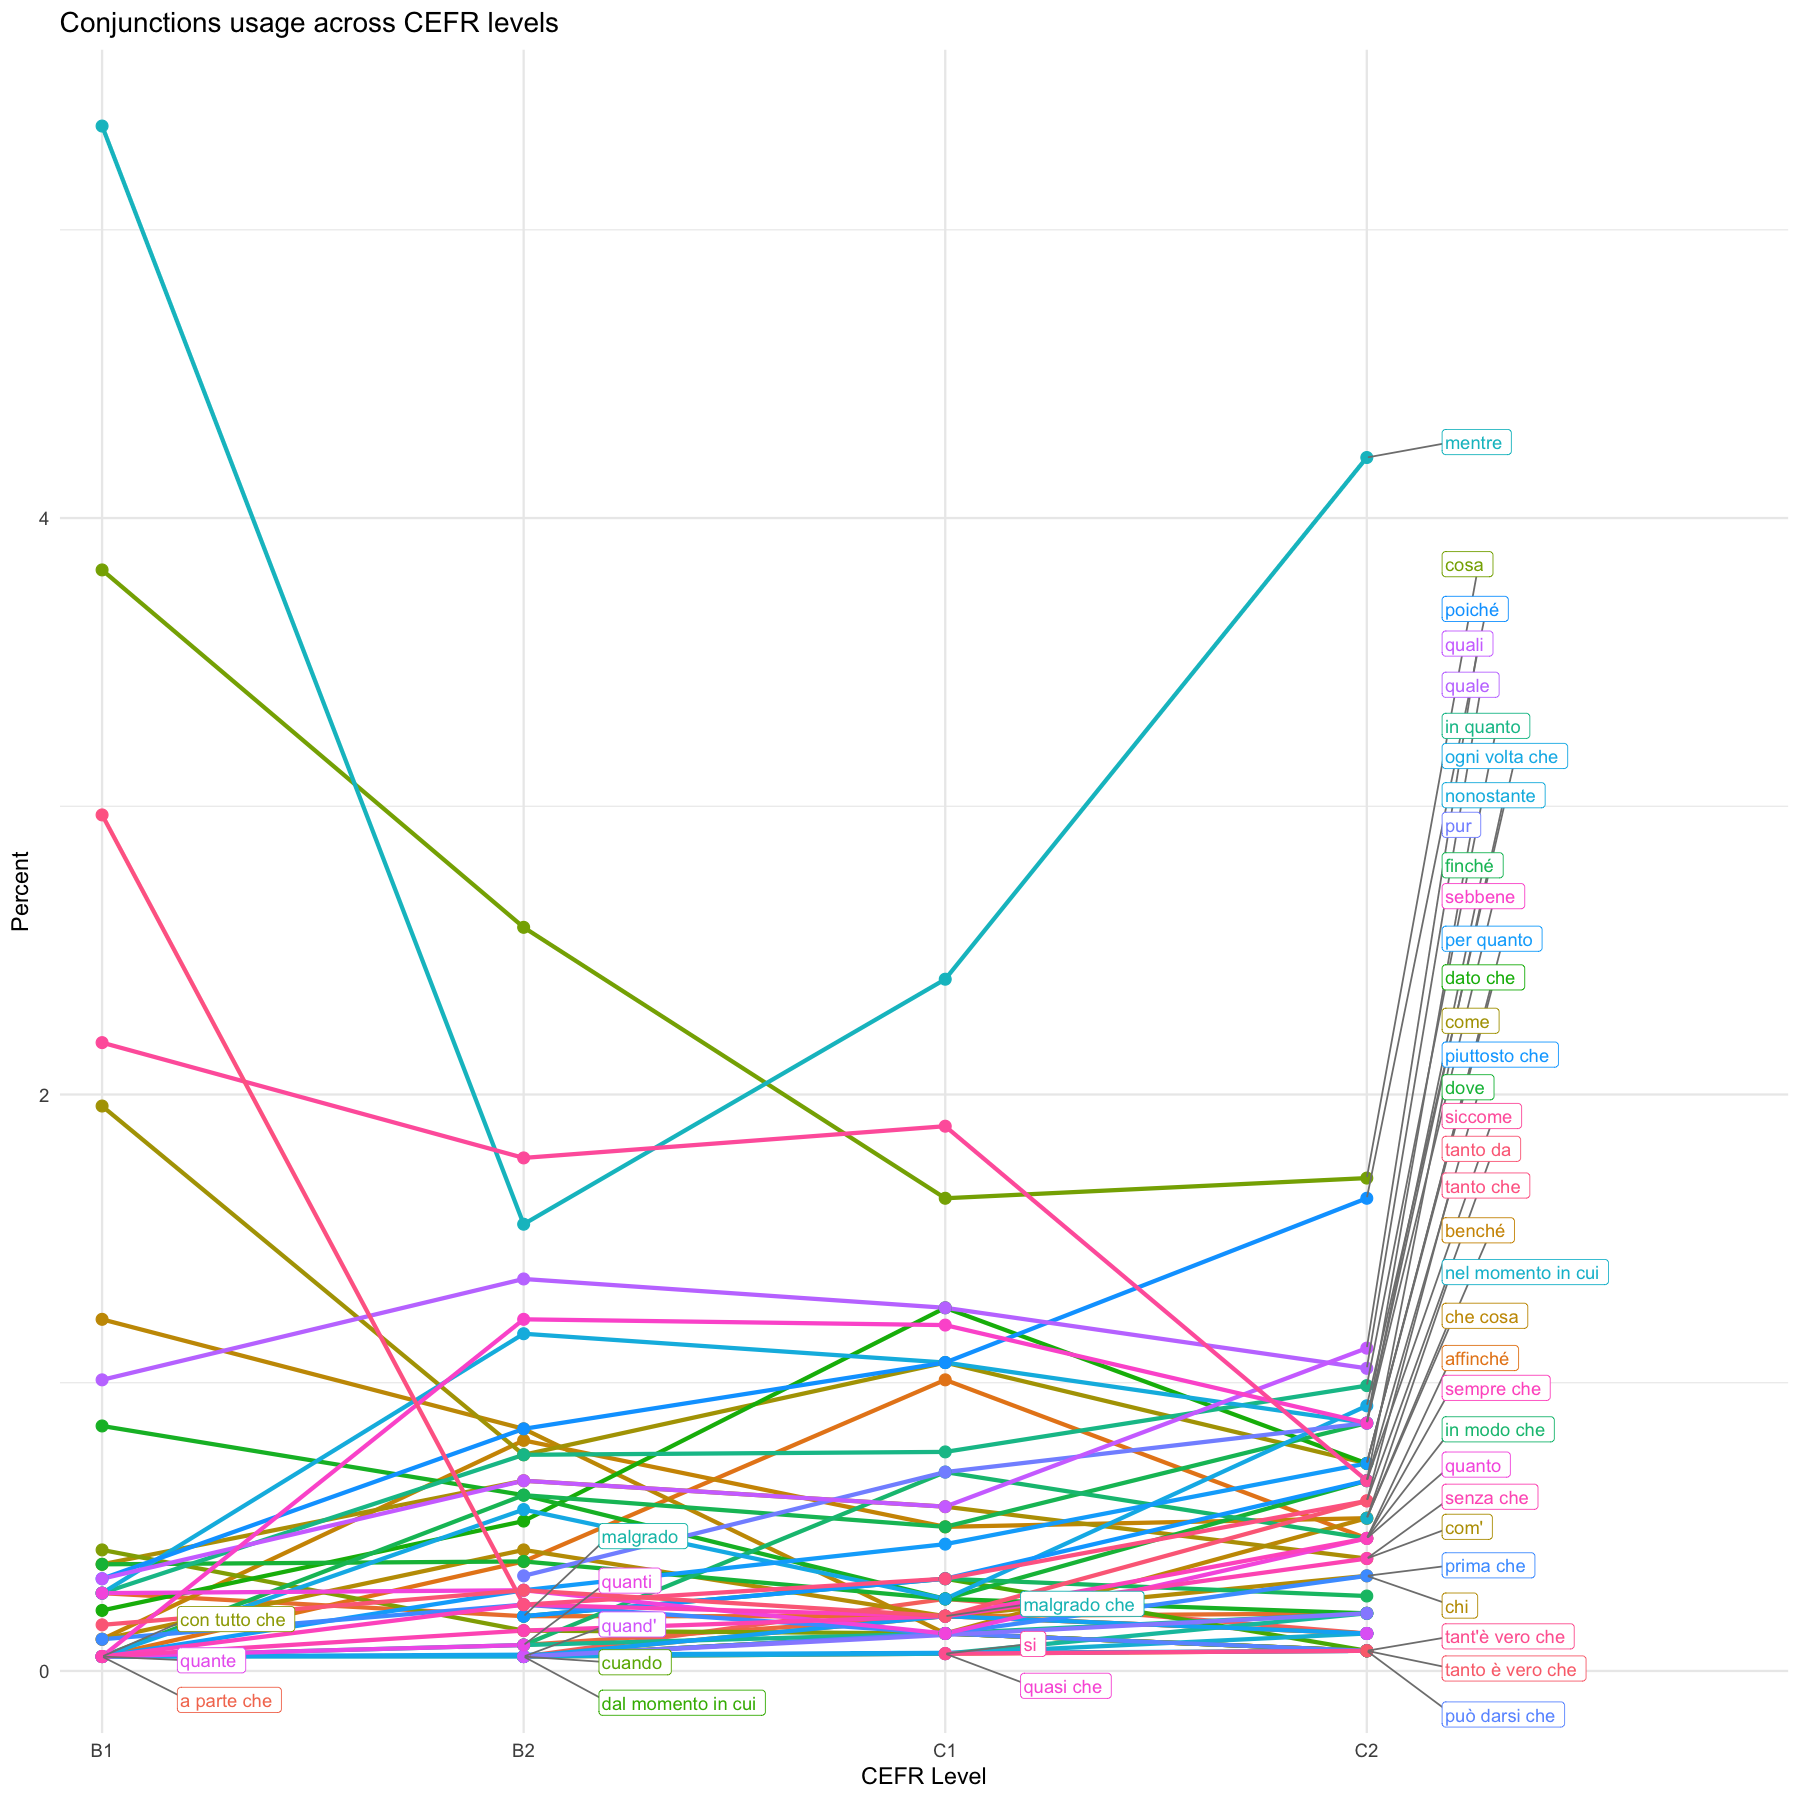

In [27]:
options(repr.plot.width = 15, repr.plot.height = 15)

data_lower %>%
  filter(!lemma %in% c("se", "quando", "perché")) %>%
  ggplot(aes(x = livello_CEFR, y = percent, color = lemma, group = lemma)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 3) +
  geom_label_repel(
    data = data_lower %>%
           filter(!lemma %in% c("se", "quando", "perché")) %>% 
           group_by(lemma) %>% 
           filter(livello_CEFR == max(livello_CEFR)),
    aes(label = lemma),
    nudge_x = 0.2,
    direction = "y",
    hjust = 0,
    segment.color = "grey50"
  ) +
  scale_x_discrete(expand = expansion(add = c(0.1, 1))) + # Give space on the right for labels
  labs(title = "Conjunctions usage across CEFR levels",
       x = "CEFR Level",
       y = "Percent") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none")